In [120]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk import FreqDist
from wordcloud import WordCloud
import seaborn as sns

In [10]:
training = pd.read_csv('train.csv')
resources = pd.read_csv('cleaned_resources.csv')

In [11]:
resources = resources.drop(['Unnamed: 0'], 1)

In [12]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [13]:
resources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260115 entries, 0 to 260114
Data columns (total 3 columns):
id             260115 non-null object
quantity       260115 non-null int64
total_price    260115 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.0+ MB


In [14]:
training['project_submitted_datetime'] = pd.to_datetime(training['project_submitted_datetime'])

In [15]:
training = training.merge(resources, how='left', left_on='id', right_on='id')

In [84]:
training.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,Music,Nutrition Education,Other,Parent Involvement,Performing Arts,Social Sciences,Special Needs_y,Team Sports,Visual Arts,Warmth Care & Hunger_y
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
training['project_is_approved'].value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

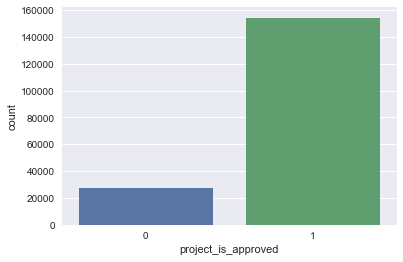

In [18]:
sns.countplot(x='project_is_approved', data=training)
plt.show()

In [19]:
training.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,quantity,total_price
count,182080.000000,182080.000000,182080.000000,182080.000000
mean,11.237055,0.847682,16.971447,545.748958
std,28.016086,0.359330,26.241957,548.198713
min,0.000000,0.000000,1.000000,100.000000
25%,0.000000,1.000000,4.000000,245.997500
50%,2.000000,1.000000,9.000000,397.750000
75%,9.000000,1.000000,21.000000,691.920000
max,451.000000,1.000000,930.000000,15299.690000


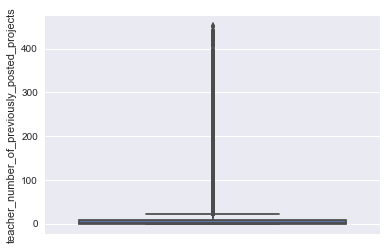

In [20]:
sns.boxplot(training['teacher_number_of_previously_posted_projects'], orient='v')
plt.show()

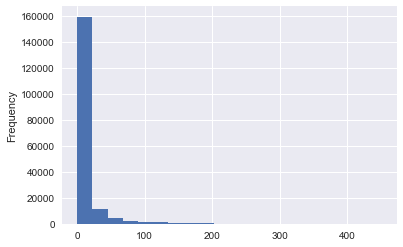

In [21]:
training['teacher_number_of_previously_posted_projects'].plot.hist(bins=20)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


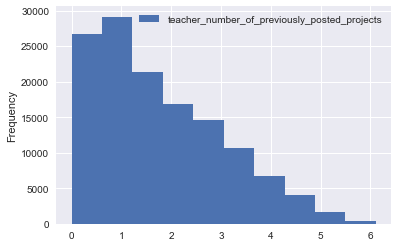

In [22]:
log_project = pd.DataFrame(np.log(training[['teacher_number_of_previously_posted_projects']]))

log_project[log_project['teacher_number_of_previously_posted_projects'] != -float('inf')].plot.hist(bins=10)
plt.show()

In [23]:
training['teacher_number_of_previously_posted_projects'].mean(), training['teacher_number_of_previously_posted_projects'].std()

(11.237055140597539, 28.01608601938684)

In [24]:
11.23 + (28.02 * 2)

67.27

In [25]:
training = training[training['teacher_number_of_previously_posted_projects'] < 67.27]

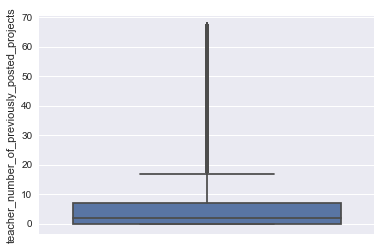

In [26]:
sns.boxplot(training['teacher_number_of_previously_posted_projects'], orient='v')
plt.show()

In [27]:
training['teacher_number_of_previously_posted_projects'].describe()

count    175379.000000
mean          6.835625
std          11.533715
min           0.000000
25%           0.000000
50%           2.000000
75%           7.000000
max          67.000000
Name: teacher_number_of_previously_posted_projects, dtype: float64

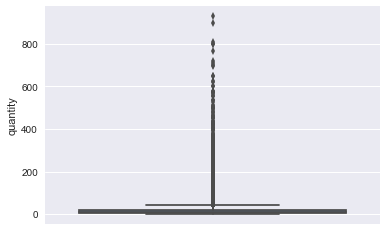

In [28]:
sns.boxplot(training['quantity'], orient='v')
plt.show()

In [29]:
training['quantity'].mean(), training['quantity'].std()

(16.915024033664235, 26.212416282914326)

In [30]:
16.92 + (2 * 26.2)

69.32

In [31]:
len(training[training['quantity'] > 69.32])

6063

In [32]:
training = training[training['quantity'] < 69.32]

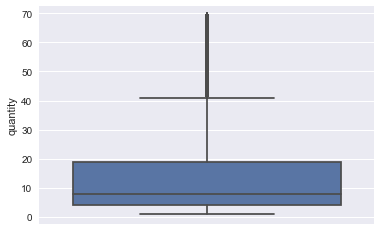

In [33]:
sns.boxplot(training['quantity'], orient='v')
plt.show()

In [34]:
training['total_price'].mean(), training['total_price'].std()

(537.268108861507, 533.0489545172296)

In [35]:
537.27 + (2 * 533.05)

1603.37

In [36]:
len(training[training['total_price'] > 1603.37])

6288

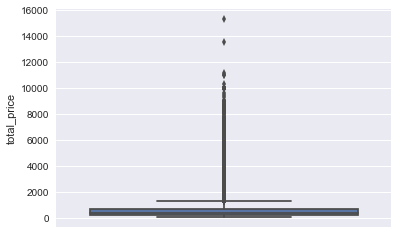

In [37]:
sns.boxplot(training['total_price'], orient='v')
plt.show()

In [38]:
training = training[training['total_price'] < 1603.37]

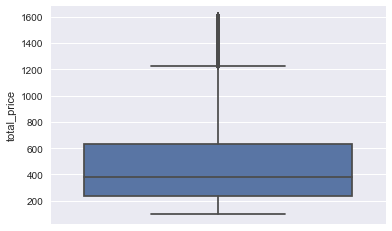

In [39]:
sns.boxplot(training['total_price'], orient='v')
plt.show()

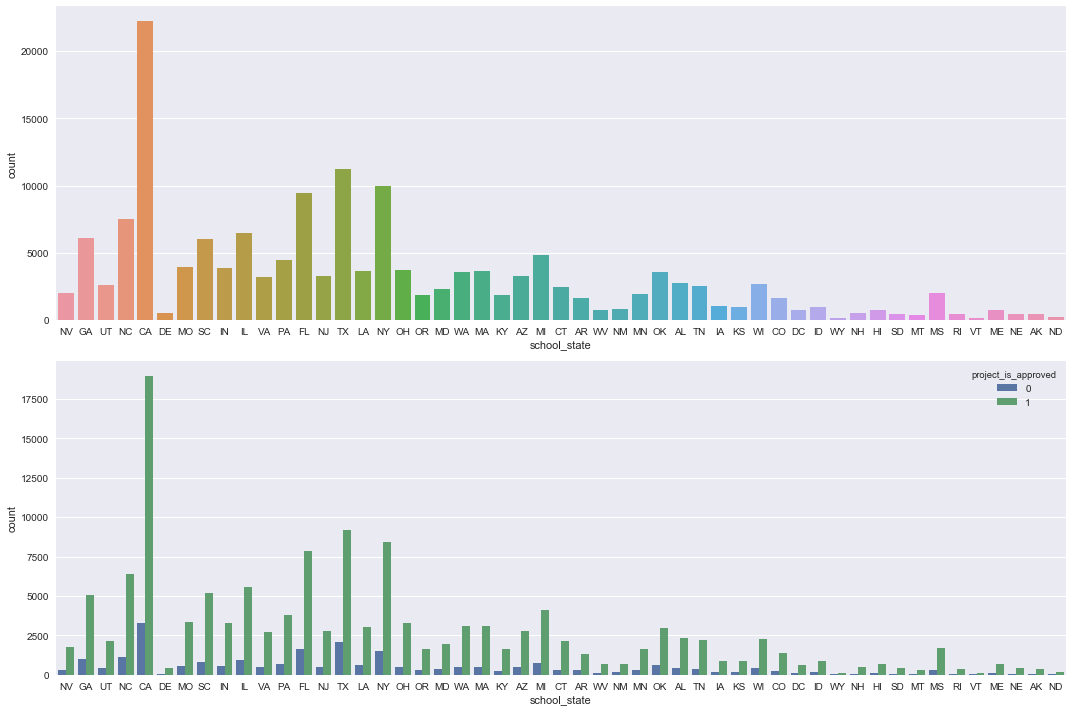

In [40]:
import seaborn as sns
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.countplot(x='school_state', data=training)

plt.subplot(2,1,2)
sns.countplot(x='school_state', hue='project_is_approved', data=training)

plt.tight_layout()
plt.show()

In [46]:
state_counts = pd.DataFrame(training['school_state'].value_counts())

In [48]:
state_counts['state'] = state_counts.index
state_counts.reset_index(drop=True, inplace=True)
state_counts.head()

,school_state,state
0,22209,CA
1,11236,TX
2,9936,NY
3,9481,FL
4,7500,NC


In [56]:
import plotly as py
py.tools.set_credentials_file(username='matthewcassi', api_key='FRBXjPQX0Xkx8wtIerG0')

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

state_counts['text'] = 'Number of Applications ' + state_counts['school_state'].astype('str')

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_counts['state'],
        z = state_counts['school_state'],
        locationmode = 'USA-states',
        text = state_counts['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of Apps")
        ) ]

layout = dict(
        title = 'Number of DonorsChoose Applications by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.plotly.iplot( fig, filename='donors_choose' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~matthewcassi/0 or inside your plot.ly account where it is named 'donors_choose'


In [41]:
state = pd.pivot_table(training, index='school_state', columns='project_is_approved', values='id', aggfunc=len)

In [42]:
state['per_rejected'] = (state[0]) / (state[0] + state[1])
state['per_approved'] = (state[1]) / (state[0] + state[1])

In [43]:
state['per_approved_total'] = (state[1]) / (state[1].sum(axis=0))

In [44]:
state['per_rejected_total'] = (state[0]) / (state[0].sum(axis=0))

In [45]:
state

project_is_approved,0,1,per_rejected,per_approved,per_approved_total,per_rejected_total
school_state,,,,,,
AK,72,390,0.155844,0.844156,0.002826,0.002880
AL,415,2329,0.151239,0.848761,0.016874,0.016599
AR,271,1343,0.167906,0.832094,0.009730,0.010839
AZ,522,2778,0.158182,0.841818,0.020127,0.020878
CA,3254,18955,0.146517,0.853483,0.137329,0.130150
CO,262,1404,0.157263,0.842737,0.010172,0.010479
CT,319,2116,0.131006,0.868994,0.015330,0.012759
DC,135,615,0.180000,0.820000,0.004456,0.005400
DE,57,460,0.110251,0.889749,0.003333,0.002280


In [57]:
training['teacher_prefix'].value_counts()

Mrs.       86638
Ms.        57905
Mr.        14917
Teacher     3541
Dr.           23
Name: teacher_prefix, dtype: int64

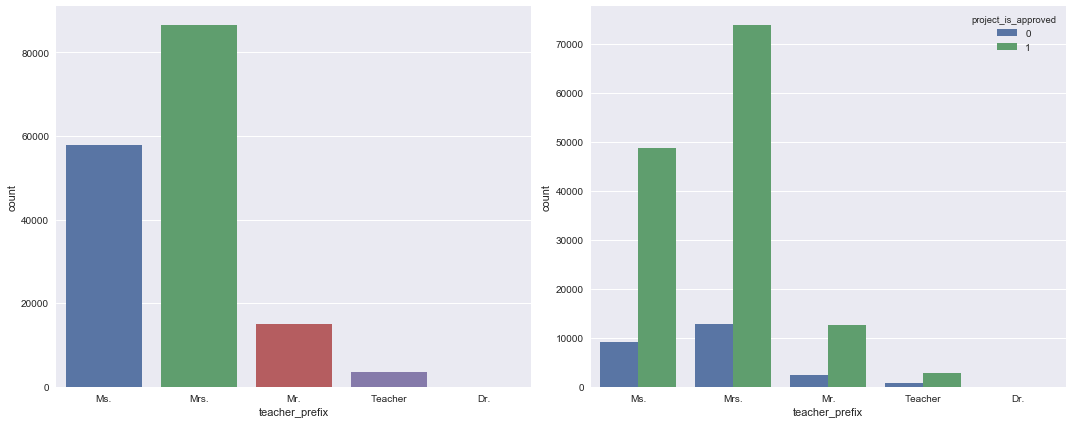

In [58]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='teacher_prefix', data=training)

plt.subplot(1,2,2)
sns.countplot(x='teacher_prefix', hue='project_is_approved', data=training)

plt.tight_layout()
plt.show()

In [59]:
teacher = pd.pivot_table(training, index='teacher_prefix', columns='project_is_approved', values='id', aggfunc=len)

In [60]:
teacher['per_rejected'] = (teacher[0]) / (teacher[0] + teacher[1])
teacher['per_approved'] = (teacher[1]) / (teacher[0] + teacher[1])
teacher['per_approved_total'] = (teacher[1]) / ( teacher[1].sum(axis=0))
teacher['per_rejected_total'] = (teacher[0]) / (teacher[0].sum(axis=0))

In [61]:
teacher

project_is_approved,0,1,per_rejected,per_approved,per_approved_total,per_rejected_total
teacher_prefix,,,,,,
Dr.,5,18,0.217391,0.782609,0.000130,0.000200
Mr.,2359,12558,0.158142,0.841858,0.090985,0.094352
Mrs.,12754,73884,0.147210,0.852790,0.535306,0.510119
Ms.,9161,48744,0.158207,0.841793,0.353161,0.366411
Teacher,723,2818,0.204180,0.795820,0.020417,0.028918


In [62]:
training['project_grade_category'].value_counts()

Grades PreK-2    68183
Grades 3-5       55394
Grades 6-8       24228
Grades 9-12      15223
Name: project_grade_category, dtype: int64

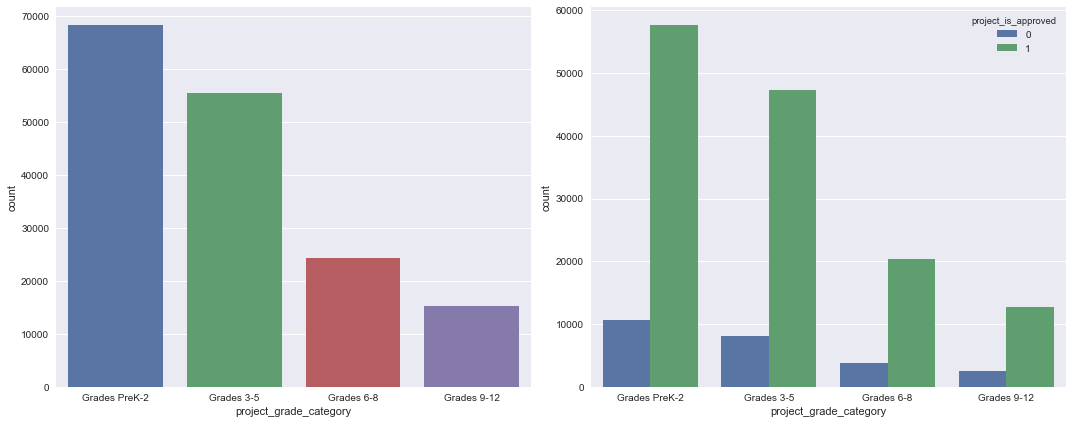

In [63]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='project_grade_category', data=training)

plt.subplot(1,2,2)
sns.countplot(x='project_grade_category', hue='project_is_approved', data=training)

plt.tight_layout()
plt.show()

In [64]:
grade = pd.pivot_table(training, index='project_grade_category', columns='project_is_approved', values='id', aggfunc=len)

In [65]:
grade['per_rejected'] = (grade[0]) / (grade[0] + grade[1])
grade['per_approved'] = (grade[1]) / (grade[0] + grade[1])
grade['per_approved_total'] = (grade[1]) / ( grade[1].sum(axis=0))
grade['per_rejected_total'] = (grade[0]) / (grade[0].sum(axis=0))

In [66]:
grade

project_is_approved,0,1,per_rejected,per_approved,per_approved_total,per_rejected_total
project_grade_category,,,,,,
Grades 3-5,8128,47266,0.146731,0.853269,0.342443,0.325094
Grades 6-8,3800,20428,0.156843,0.843157,0.148001,0.151988
Grades 9-12,2508,12715,0.164751,0.835249,0.092120,0.100312
Grades PreK-2,10566,57617,0.154965,0.845035,0.417436,0.422606


In [67]:
training['project_subject_categories'].value_counts()

Literacy & Language                           35265
Math & Science                                25436
Literacy & Language, Math & Science           22642
Health & Sports                               15379
Music & The Arts                               7141
Special Needs                                  6684
Literacy & Language, Special Needs             6081
Applied Learning                               5780
Math & Science, Literacy & Language            3327
Applied Learning, Literacy & Language          3312
Math & Science, Special Needs                  2709
History & Civics                               2684
Literacy & Language, Music & The Arts          2460
Applied Learning, Special Needs                2316
Math & Science, Music & The Arts               2295
Health & Sports, Special Needs                 2238
History & Civics, Literacy & Language          1925
Math & Science, Applied Learning               1793
Warmth, Care & Hunger                          1761
Applied Lear

In [68]:
training['project_subject_categories'].unique()

array(['Literacy & Language', 'Music & The Arts, Health & Sports',
       'Math & Science, Literacy & Language', 'Health & Sports',
       'Applied Learning, Literacy & Language', 'Math & Science',
       'Literacy & Language, Math & Science', 'Special Needs',
       'Applied Learning, Special Needs',
       'Applied Learning, Music & The Arts',
       'Math & Science, Special Needs', 'Health & Sports, Special Needs',
       'Literacy & Language, History & Civics',
       'Health & Sports, Literacy & Language', 'Music & The Arts',
       'Literacy & Language, Special Needs',
       'Special Needs, Music & The Arts', 'History & Civics',
       'Math & Science, Applied Learning',
       'Literacy & Language, Music & The Arts',
       'Math & Science, Music & The Arts',
       'History & Civics, Special Needs',
       'History & Civics, Literacy & Language', 'Applied Learning',
       'Math & Science, History & Civics',
       'Applied Learning, Math & Science',
       'Health & Sports, A

In [69]:
len(training['project_subject_categories'].unique())

51

In [70]:
training['project_subject_subcategories'].value_counts()

Literacy                                        14441
Literacy, Mathematics                           12964
Literature & Writing, Mathematics                9083
Mathematics                                      8229
Literacy, Literature & Writing                   8180
Special Needs                                    6684
Literature & Writing                             6565
Health & Wellness                                5546
Applied Sciences, Mathematics                    5116
Literacy, Special Needs                          3729
Applied Sciences                                 3667
Gym & Fitness, Health & Wellness                 3493
ESL, Literacy                                    3308
Visual Arts                                      2993
Music                                            2130
Literature & Writing, Special Needs              2040
Health & Wellness, Special Needs                 1935
Gym & Fitness                                    1808
Mathematics, Special Needs  

In [71]:
training['project_subject_categories'] = training['project_subject_categories'].str.replace('Warmth, Care & Hunger', 'Warmth Care & Hunger')

In [72]:
training['project_subject_subcategories'] = training['project_subject_subcategories'].str.replace('Warmth, Care & Hunger', 'Warmth Care & Hunger')

In [73]:
training['project_subject_subcategories'].value_counts()

Literacy                                        14441
Literacy, Mathematics                           12964
Literature & Writing, Mathematics                9083
Mathematics                                      8229
Literacy, Literature & Writing                   8180
Special Needs                                    6684
Literature & Writing                             6565
Health & Wellness                                5546
Applied Sciences, Mathematics                    5116
Literacy, Special Needs                          3729
Applied Sciences                                 3667
Gym & Fitness, Health & Wellness                 3493
ESL, Literacy                                    3308
Visual Arts                                      2993
Music                                            2130
Literature & Writing, Special Needs              2040
Health & Wellness, Special Needs                 1935
Gym & Fitness                                    1808
Mathematics, Special Needs  

In [74]:
training['project_subject_categories'] = list(training['project_subject_categories'].str.split(r', '))

In [75]:
training['project_subject_categories'][3]

['Health & Sports']

In [76]:
training1 = training['project_subject_categories'].apply(collections.Counter)
training1 = pd.DataFrame.from_records(training1).fillna(value=0)

In [77]:
training['project_subject_subcategories'] = list(training['project_subject_subcategories'].str.split(r', '))

In [78]:
training['project_subject_subcategories'][2]

['Applied Sciences', 'Literature & Writing']

In [79]:
training2 = training['project_subject_subcategories'].apply(collections.Counter)
training2 = pd.DataFrame.from_records(training2).fillna(value=0)

In [80]:
training = training.merge(training1, how='left', left_index=True, right_index=True)

In [81]:
training = training.merge(training2, how='left', left_index=True, right_index=True)

In [82]:
training.drop(['project_subject_subcategories', 'project_subject_categories'], 1, inplace=True)

In [83]:
training.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,Music,Nutrition Education,Other,Parent Involvement,Performing Arts,Social Sciences,Special Needs_y,Team Sports,Visual Arts,Warmth Care & Hunger_y
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
list(training.columns)

['id',
 'teacher_id',
 'teacher_prefix',
 'school_state',
 'project_submitted_datetime',
 'project_grade_category',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_essay_3',
 'project_essay_4',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects',
 'project_is_approved',
 'quantity',
 'total_price',
 'Applied Learning',
 'Health & Sports',
 'History & Civics',
 'Literacy & Language',
 'Math & Science',
 'Music & The Arts',
 'Special Needs_x',
 'Warmth Care & Hunger_x',
 'Applied Sciences',
 'Character Education',
 'Civics & Government',
 'College & Career Prep',
 'Community Service',
 'ESL',
 'Early Development',
 'Economics',
 'Environmental Science',
 'Extracurricular',
 'Financial Literacy',
 'Foreign Languages',
 'Gym & Fitness',
 'Health & Life Science',
 'Health & Wellness',
 'History & Geography',
 'Literacy',
 'Literature & Writing',
 'Mathematics',
 'Music',
 'Nutrition Education',
 'Other',
 'Parent Involvement',
 'Performing Arts',

In [105]:
cat_totals = pd.DataFrame(training.loc[:,'Applied Learning':'Applied Sciences'].sum(axis=0))

In [106]:
cat_totals['category'] = cat_totals.index
cat_totals.columns = ['count','category']
cat_totals.reset_index(drop=True, inplace=True)
cat_totals

,count,category
0,16307.0,Applied Learning
1,19502.0,Health & Sports
2,7417.0,History & Civics
3,70134.0,Literacy & Language
4,55617.0,Math & Science
5,12739.0,Music & The Arts
6,18887.0,Special Needs_x
7,1663.0,Warmth Care & Hunger_x
8,14210.0,Applied Sciences


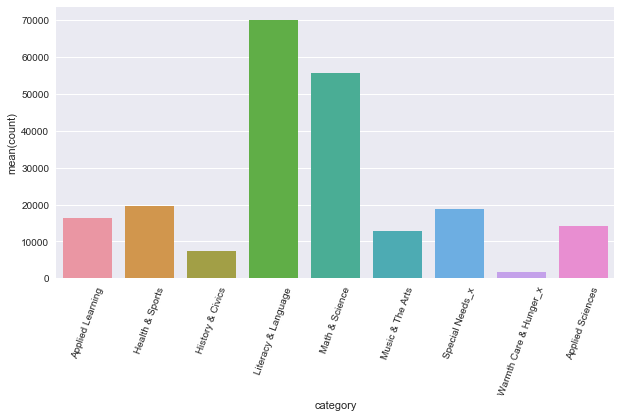

In [110]:
plt.figure(figsize=(10,5))
sns.barplot(x='category', y='count', data=cat_totals)
plt.xticks(rotation=70)
plt.show()

In [108]:
subcat_totals = pd.DataFrame(training.loc[:,'Applied Sciences':].sum(axis=0))
subcat_totals['category'] = subcat_totals.index
subcat_totals.columns = ['count','category']
subcat_totals.reset_index(drop=True, inplace=True)

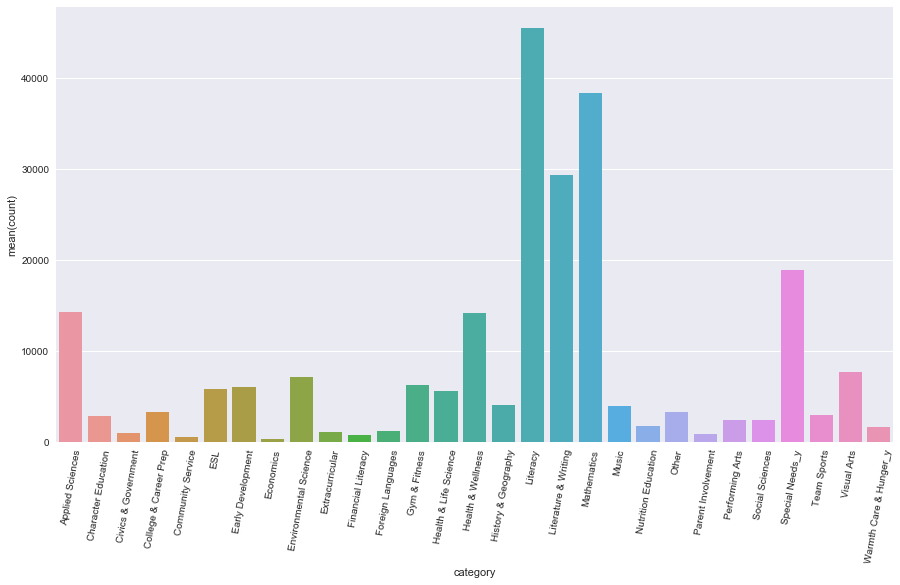

In [109]:
plt.figure(figsize=(15,8))
sns.barplot(x='category', y='count', data=subcat_totals)
plt.xticks(rotation=80)
plt.show()

In [114]:
training['project_title'] = training['project_title'].str.lower()
training['project_essay_1'] = training['project_essay_1'].str.lower()
training['project_essay_2'] = training['project_essay_2'].str.lower()
training['project_essay_3'] = training['project_essay_3'].str.lower()
training['project_essay_4'] = training['project_essay_4'].str.lower()

In [121]:
training['project_title'] = training['project_title'].str.replace(r'[^a-zA-Z ]+', '')

In [118]:
training['project_essay_1'] = training['project_essay_1'].str.replace(r'[^a-zA-Z ]+', '')
training['project_essay_2'] = training['project_essay_2'].str.replace(r'[^a-zA-Z ]+', '')
training['project_essay_3'] = training['project_essay_3'].str.replace(r'[^a-zA-Z ]+', '')
training['project_essay_4'] = training['project_essay_4'].str.replace(r'[^a-zA-Z ]+', '')

In [130]:
training['project_essay_3'] = training['project_essay_3'].fillna('')
training['project_essay_4'] = training['project_essay_4'].fillna('')

In [131]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

training['project_title'] = training['project_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_1'] = training['project_essay_1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_2'] = training['project_essay_2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_3'] = training['project_essay_3'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_4'] = training['project_essay_4'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

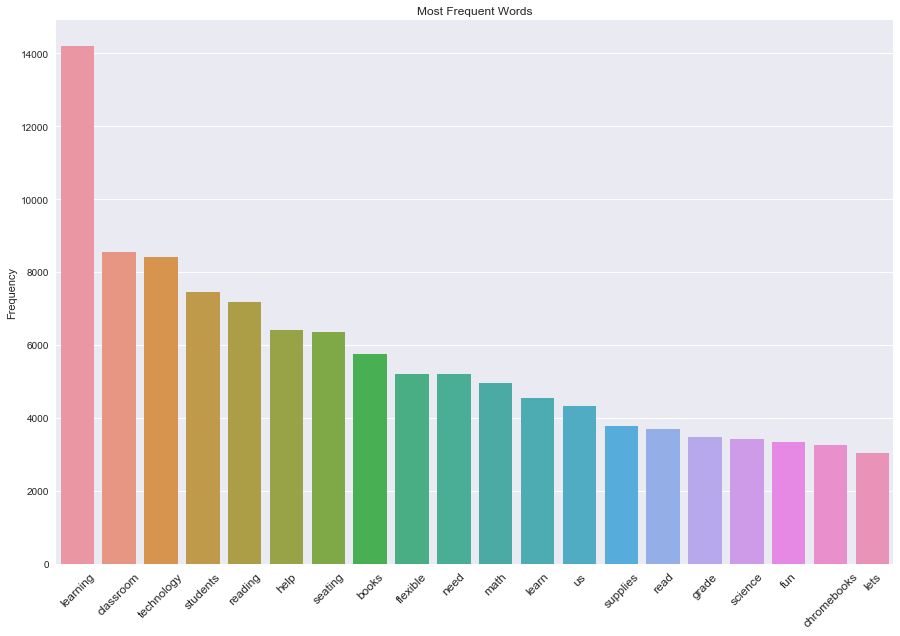

In [132]:
title = ' '.join(training['project_title'])
tokens = nltk.tokenize.word_tokenize(title)
freq = FreqDist(tokens)
freq1 = freq.most_common(20)
word, count = zip(*freq1)
word = list(word)
count = list(count)

plt.figure(figsize=(15,10))
sns.barplot(np.arange(len(word)), count)
plt.xticks(np.arange(len(word)), word, rotation=45, size='large')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

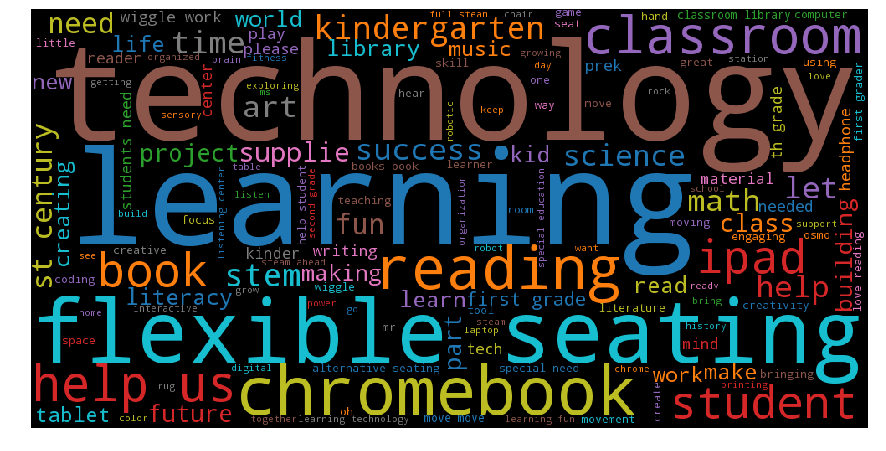

In [133]:
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab10', min_font_size=10).generate(' '.join(training['project_title']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()